# 2A.ML101.5: Measuring prediction performance

*Source:* [Course on machine learning with scikit-learn](https://github.com/GaelVaroquaux/sklearn_ensae_course) by Gaël Varoquaux

## Using the K-neighbors classifier

Here we'll continue to look at the digits data, but we'll switch to the
K-Neighbors classifier.  The K-neighbors classifier is an instance-based
classifier.  The K-neighbors classifier predicts the label of
an unknown point based on the labels of the *K* nearest points in the
parameter space.

In [1]:
# Get the data
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [2]:
# Instantiate and train the classifier
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [3]:
# Check the results using metrics
from sklearn import metrics
y_pred = clf.predict(X)

In [4]:
print(metrics.confusion_matrix(y_pred, y))

[[178   0   0   0   0   0   0   0   0   0]
 [  0 182   0   0   0   0   0   0   0   0]
 [  0   0 177   0   0   0   0   0   0   0]
 [  0   0   0 183   0   0   0   0   0   0]
 [  0   0   0   0 181   0   0   0   0   0]
 [  0   0   0   0   0 182   0   0   0   0]
 [  0   0   0   0   0   0 181   0   0   0]
 [  0   0   0   0   0   0   0 179   0   0]
 [  0   0   0   0   0   0   0   0 174   0]
 [  0   0   0   0   0   0   0   0   0 180]]


Apparently, we've found a perfect classifier!  But this is misleading
for the reasons we saw before: the classifier essentially "memorizes"
all the samples it has already seen.  To really test how well this
algorithm does, we need to try some samples it *hasn't* yet seen.

This problem can also occur with regression models. In the following we fit an other instance-based model named "decision tree" to the Boston Housing price dataset we introduced previously:

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

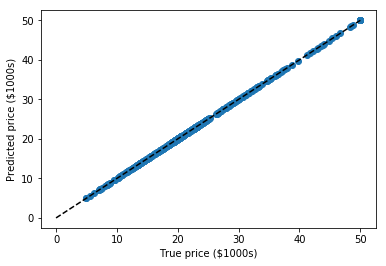

In [6]:
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor

data = load_boston()
clf = DecisionTreeRegressor().fit(data.data, data.target)
predicted = clf.predict(data.data)
expected = data.target

plt.scatter(expected, predicted)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price ($1000s)')
plt.ylabel('Predicted price ($1000s)');

Here again the predictions are seemingly perfect as the model was able to perfectly memorize the training set.

## A Better Approach: Using a validation set

Learning the parameters of a prediction function and testing it on the
same data is a methodological mistake: a model that would just repeat
the labels of the samples that it has just seen would have a perfect
score but would fail to predict anything useful on yet-unseen data.

To avoid over-fitting, we have to define two different sets:

- a training set X_train, y_train which is used for learning the parameters of a predictive model
- a testing set X_test, y_test which is used for evaluating the fitted predictive model

In scikit-learn such a random split can be quickly computed with the
`train_test_split` helper function.  It can be used this way:

In [7]:
from sklearn import cross_validation
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,
                                        test_size=0.25, random_state=0)

print("%r, %r, %r" % (X.shape, X_train.shape, X_test.shape))

(1797, 64), (1347, 64), (450, 64)


c:\python370_x64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now we train on the training data, and test on the testing data:

In [8]:
clf = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [9]:
print(metrics.confusion_matrix(y_test, y_pred))

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  0  0  0  0  0]
 [ 0  0 43  1  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  0  0  0  0 47  0  0  0  1]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  0  0  0  0  0  0 48  0  0]
 [ 0  0  0  0  0  0  0  0 48  0]
 [ 0  0  0  1  0  1  0  0  0 45]]


In [10]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       1.00      1.00      1.00        43
          2       1.00      0.98      0.99        44
          3       0.96      1.00      0.98        45
          4       1.00      1.00      1.00        38
          5       0.98      0.98      0.98        48
          6       1.00      1.00      1.00        52
          7       1.00      1.00      1.00        48
          8       1.00      1.00      1.00        48
          9       0.98      0.96      0.97        47

avg / total       0.99      0.99      0.99       450



The averaged f1-score is often used as a convenient measure of the
overall performance of an algorithm.  It appears in the bottom row
of the classification report; it can also be accessed directly:

In [11]:
metrics.f1_score(y_test, y_pred, average="macro")

0.9913675218842191

The over-fitting we saw previously can be quantified by computing the
f1-score on the training data itself:

In [12]:
metrics.f1_score(y_train, clf.predict(X_train), average="macro")

1.0

**Regression metrics** In the case of regression models, we need to use different metrics, such as explained variance.

## Application: Model Selection via Validation

In the previous notebook, we saw Gaussian Naive Bayes classification of the digits.
Here we saw K-neighbors classification of the digits.  We've also seen support vector
machine classification of digits.  Now that we have these
validation tools in place, we can ask quantitatively which of the three estimators
works best for the digits dataset.

- With the default hyper-parameters for each estimator, which gives the best f1 score
  on the **validation set**?  Recall that hyperparameters are the parameters set when
  you instantiate the classifier: for example, the ``n_neighbors`` in

          clf = KNeighborsClassifier(n_neighbors=1)

- For each classifier, which value for the hyperparameters gives the best results for
  the digits data?  For ``LinearSVC``, use ``loss='l2'`` and ``loss='l1'``.  For
  ``KNeighborsClassifier`` we use ``n_neighbors`` between 1 and 10.  Note that ``GaussianNB``
  does not have any adjustable hyperparameters.

In [13]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import warnings  # suppress warnings from older versions of KNeighbors
warnings.filterwarnings('ignore', message='kneighbors*')

X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,
                            test_size=0.25, random_state=0)

for Model in [LinearSVC, GaussianNB, KNeighborsClassifier]:
    clf = Model().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(Model.__name__,
          metrics.f1_score(y_test, y_pred, average="macro"))
    
print('------------------')

# test SVC loss
for loss in ['l1', 'l2']:
    clf = LinearSVC(loss=loss).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("LinearSVC(loss='{0}')".format(loss),
          metrics.f1_score(y_test, y_pred, average="macro"))
    
print('-------------------')
    
# test K-neighbors
for n_neighbors in range(1, 11):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("KNeighbors(n_neighbors={0})".format(n_neighbors),
          metrics.f1_score(y_test, y_pred, average="macro"))


LinearSVC 0.9298297872289514
GaussianNB 0.8332741681010101
KNeighborsClassifier 0.9804562804949924
------------------


c:\python370_x64\lib\site-packages\sklearn\svm\classes.py:219: DeprecationWarning: loss='l1' has been deprecated in favor of loss='hinge' as of 0.16. Backward compatibility for the loss='l1' will be removed in 1.0
  DeprecationWarning)


LinearSVC(loss='l1') 0.9340408853394493


c:\python370_x64\lib\site-packages\sklearn\svm\classes.py:219: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


LinearSVC(loss='l2') 0.9363168390138735
-------------------
KNeighbors(n_neighbors=1) 0.9913675218842191
KNeighbors(n_neighbors=2) 0.9848442068835102
KNeighbors(n_neighbors=3) 0.9867753449543099
KNeighbors(n_neighbors=4) 0.9803719053818863
KNeighbors(n_neighbors=5) 0.9804562804949924
KNeighbors(n_neighbors=6) 0.9757924194139573
KNeighbors(n_neighbors=7) 0.9780645792142071
KNeighbors(n_neighbors=8) 0.9780645792142071
KNeighbors(n_neighbors=9) 0.9780645792142071
KNeighbors(n_neighbors=10) 0.9755550897728812


## Cross-validation

Cross-validation consists in repetively splitting the data in pairs of train and test sets, called 'folds'. Scikit-learn comes with a function to automatically compute score on all these folds. Here we do 'K-fold' with k=5.

In [14]:
clf = KNeighborsClassifier()
from sklearn.cross_validation import cross_val_score
cross_val_score(clf, X, y, cv=5)

array([0.9478022 , 0.9558011 , 0.96657382, 0.98039216, 0.96338028])

We can use different splitting strategies, such as random splitting

In [15]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(n=len(X), n_iter=5)
cross_val_score(clf, X, y, cv=cv)

array([0.99444444, 0.97777778, 0.99444444, 0.99444444, 0.98888889])

There exists many different cross-validation strategies in scikit-learn. They are often useful to take in account non iid datasets.

## Hyperparameter optimization with cross-validation

Consider regularized linear models, such as
*Ridge Regression*, which uses $\ell_2$ regularlization,
and *Lasso Regression*, which uses $\ell_1$ regularization. Choosing their regularization parameter is important.

Let us set these paramaters on the Diabetes dataset, a simple regression problem. The diabetes data consists of 10 physiological variables (age, sex, weight, blood pressure) measure on 442 patients, and an indication of disease progression after one year:

In [16]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target
print(X.shape)

(442, 10)


With the default hyper-parameters: we use the cross-validation score to determine goodness-of-fit:

In [17]:
from sklearn.linear_model import Ridge, Lasso

for Model in [Ridge, Lasso]:
    model = Model()
    print(Model.__name__, cross_val_score(model, X, y).mean())

Ridge 0.40942743830329875
Lasso 0.35380008329932017


### Basic Hyperparameter Optimization

We compute the cross-validation score as a function of alpha, the strength of the regularization for Lasso and Ridge. We choose 20 values of alpha between 0.0001 and 1:

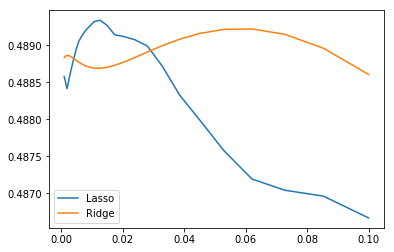

In [18]:
alphas = np.logspace(-3, -1, 30)

for Model in [Lasso, Ridge]:
    scores = [cross_val_score(Model(alpha), X, y, cv=3).mean()
              for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)
plt.legend(loc='lower left');

Can we trust our results to be actually useful?

### Automatically Performing Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV

``GridSearchCV`` is constructed with an estimator, as well as a dictionary
of parameter values to be searched.  We can find the optimal parameters this
way:

In [20]:
for Model in [Ridge, Lasso]:
    gscv = GridSearchCV(Model(), dict(alpha=alphas), cv=3).fit(X, y)
    print(Model.__name__, gscv.best_params_)

Ridge {'alpha': 0.06210169418915616}
Lasso {'alpha': 0.01268961003167922}


### Built-in Hyperparameter Search

For some models within scikit-learn, cross-validation can be performed more efficiently
on large datasets.  In this case, a cross-validated version of the particular model is
included.  The cross-validated versions of ``Ridge`` and ``Lasso`` are ``RidgeCV`` and
``LassoCV``, respectively.  The grid search on these estimators can be performed as
follows:

In [21]:
from sklearn.linear_model import RidgeCV, LassoCV
for Model in [RidgeCV, LassoCV]:
    model = Model(alphas=alphas, cv=3).fit(X, y)
    print(Model.__name__, model.alpha_)

RidgeCV 0.06210169418915616
LassoCV 0.01268961003167922


We see that the results match those returned by GridSearchCV

### Nested cross-validation

How do we measure the performance of these estimators? We have used data to set the hyperparameters, so we need to test on actually new data. We can do this by running `cross_val_score` on our CV objects. Here there are 2 cross-validation loops going on, this is called 'nested cross validation':

In [22]:
for Model in [RidgeCV, LassoCV]:
    scores = cross_val_score(Model(alphas=alphas, cv=3), X, y, cv=3)
    print(Model.__name__, np.mean(scores))

RidgeCV 0.48916142454965544
LassoCV 0.48549139668647756


Note that these results do not match the best results of our curves above, and `LassoCV` seems to under-perform `RidgeCV`. The reason is that setting the hyper-parameter is harder for Lasso, thus the estimation error on this hyper-parameter is larger.